In [76]:
#class for managing interactions between model and podcast database.
import pickle
import time
import pandas as pd
import gensim
import numpy as np
import scipy
from sklearn import decomposition
from matplotlib import pyplot as plt
import matplotlib

class PodcastDB:
    

    #initialize object
    def __init__(self,fid=None,model=None):
        if(fid is not None):
            self.podcastdb = pickle.load(fid)
            self.w2vs = [v for v in self.podcastdb['w2v']]
            self.npodcast = self.podcastdb.shape[0]
        else:
            self.podcastdb = None
            self.w2vs = None
            self.npodcast = 0
            
        if(model is not None):
            self.model = model
        else:
            self.model = None
            
    #primary method. finds podcasts most similar to some word.
    def find_similar(self,word,n_outputs=10):
        assert((self.podcastdb is not None) and (self.model is not None))
        return self.podcastdb.iloc[self.__compare(self._evaluate(word)).argsort()[:n_outputs]]
        
    
    #apply internal model to a single word. 
    def _evaluate(self,word):
        if(isinstance(word,list)):
            return self.__evaluate_set(word)
        elif(isinstance(word,str)):
            #attempt to get vectorial representation of word.
            try:
                return self.model[word]
            except KeyError as e:
                return np.full([300,],np.nan)
        else:
            raise TypeError()
            
    #apply the model to a set of words and average them. 
    #this is simply ep2vec from other scripts.
    def __evaluate_set(self,words):
        #evaluate each word in 
        n = 0
        a = []
        for w in words:
            #attempt to evaluate vectorial representation of word.
            try:
                v = self.model[w]
                if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                    a.append(v)
                    n += 1
            except KeyError as e:
                pass
        #if nothing was valid, return nan
        if(n==0):
            return np.full([300,], np.nan)
        #return average
        return np.mean(np.array(a),axis=0)
        
    #compares vector 
    def __compare(self,u):
        #give comparator function an alias so we can change it up if desirable.
        comparator = scipy.spatial.distance.cosine
        
        #return distances between vector and all our podcasts.
        return np.array([comparator(u,v) for v in self.w2vs])
    
    

In [22]:
#load in podcast df, gensim model, and put it in the database object.

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
modelfname = 'GoogleNews-vectors-negative300.bin'
podcastfname = 'podcast_df_subset_'+'1528986544'+'.pkl'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(floc+modelfname, binary=True)


In [70]:
with open(floc+podcastfname,'rb') as fid:
    podcastdb = PodcastDB(fid=fid,model=word2vec)

In [71]:
#it actually works
podcastdb.find_similar('republican')

,artistId,artistName,artistViewUrl,artworkUrl100,artworkUrl30,artworkUrl60,artworkUrl600,collectionCensoredName,collectionExplicitness,collectionHdPrice,...,trackExplicitness,trackHdPrice,trackHdRentalPrice,trackId,trackName,trackPrice,trackRentalPrice,trackViewUrl,wrapperType,w2v
246859,NaN,KBFS/KYDT,NaN,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,KBFS/KYDT,cleaned,0,...,cleaned,0,0,1376916755,KBFS/KYDT,0.0,0,https://itunes.apple.com/us/podcast/kbfs-kydt/...,track,"[-0.0023903262, -0.08363211, 0.015164621, 0.13..."
240533,NaN,GateHouse Media,NaN,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,Austin American-Statesman,cleaned,0,...,cleaned,0,0,1380736853,Austin American-Statesman,0.0,0,https://itunes.apple.com/us/podcast/austin-ame...,track,"[-0.009545326, -0.0040668095, 0.031749334, 0.1..."
248778,NaN,Tim Bryant,NaN,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,Mission: TimPossible,cleaned,0,...,cleaned,0,0,1268019087,Mission: TimPossible,0.0,0,https://itunes.apple.com/us/podcast/mission-ti...,track,"[-0.019660177, 0.014805593, 0.005857739, 0.048..."
256110,NaN,The Cap Times,NaN,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,Wedge Issues,cleaned,0,...,cleaned,0,0,1385156002,Wedge Issues,0.0,0,https://itunes.apple.com/us/podcast/wedge-issu...,track,"[0.024533238, 0.018209007, -0.029966068, 0.061..."
253541,NaN,Miami DSA,NaN,https://is4-ssl.mzstatic.com/image/thumb/Music...,https://is4-ssl.mzstatic.com/image/thumb/Music...,https://is4-ssl.mzstatic.com/image/thumb/Music...,https://is4-ssl.mzstatic.com/image/thumb/Music...,South Beach Socialism,cleaned,0,...,cleaned,0,0,1395528716,South Beach Socialism,0.0,0,https://itunes.apple.com/us/podcast/south-beac...,track,"[0.037867717, 0.05633925, 0.08152647, 0.250553..."
250900,NaN,jridgell,NaN,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,https://is3-ssl.mzstatic.com/image/thumb/Music...,Political Rewind,cleaned,0,...,cleaned,0,0,964921299,Political Rewind,0.0,0,https://itunes.apple.com/us/podcast/political-...,track,"[0.006887262, 0.030153325, 0.0027536408, 0.092..."
253896,NaN,StridentConservative,NaN,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,https://is5-ssl.mzstatic.com/image/thumb/Music...,StridentConservative,cleaned,0,...,cleaned,0,0,1294166878,StridentConservative,0.0,0,https://itunes.apple.com/us/podcast/stridentco...,track,"[0.03925987, 0.041802973, 0.013570602, 0.14181..."
246920,1.094010e+09,KET,https://itunes.apple.com/us/artist/ket/1094010...,https://is1-ssl.mzstatic.com/image/thumb/Music...,https://is1-ssl.mzstatic.com/image/thumb/Music...,https://is1-ssl.mzstatic.com/image/thumb/Music...,https://is1-ssl.mzstatic.com/image/thumb/Music...,Kentucky Tonight,cleaned,0,...,cleaned,0,0,1091020254,Kentucky Tonight,0.0,0,https://itunes.apple.com/us/podcast/kentucky-t...,track,"[-0.024658319, 0.022829559, 0.010456732, 0.100..."
172904,NaN,Patrick Pfingsten,NaN,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,https://is2-ssl.mzstatic.com/image/thumb/Music...,Forward Thinking Politics,cleaned,0,...,cleaned,0,0,1378959338,Forward Thinking Politics,0.0,0,https://itunes.appl

31311

Text(200,0.125,'expl. var of first 3: 0.27')

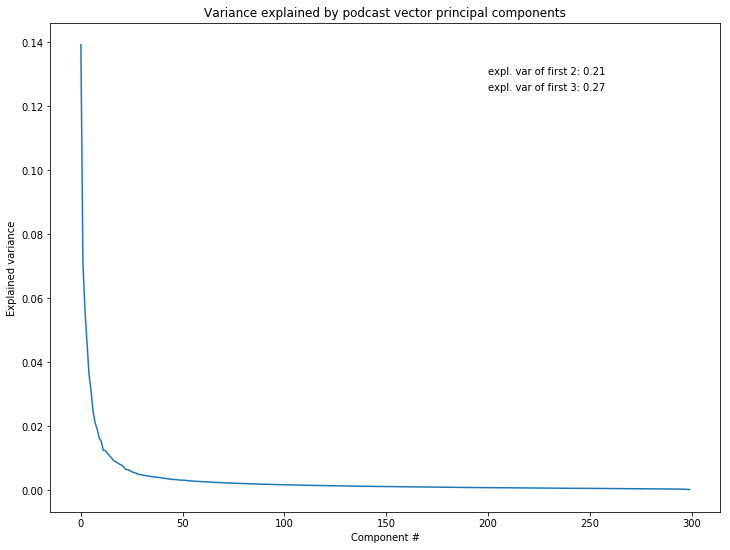

In [82]:
#perform PCA on podcast vectors
pca = sklearn.decomposition.PCA()

pca.fit(np.array(podcastdb.w2vs))

plt.figure(figsize=[12,9])
plt.plot(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel('Component #')
plt.ylabel('Explained variance')
plt.title('Variance explained by podcast vector principal components')
plt.text(200,.13,'expl. var of first 2: %.2f' % sum(pca.explained_variance_ratio_[0:2]))
plt.text(200,.125,'expl. var of first 3: %.2f' % sum(pca.explained_variance_ratio_[0:3]))

In [6]:
a = np.array([2,2,5,8])
b = np.array([3,4,9,2])

np.add(a,b)/2

array([2.5, 3. , 7. , 5. ])

In [ ]:
#Fit a gaussian mixture model for clustering
import numpy as np
from sklearn import mixture

np.array([v for v in podcast_df_subset['w2v'].get_values()]).shape#training examples
gmm = mixture.GaussianMixture(n_components=15)
podcast_topic_vec = np.array()
gmm.fit(podcast_topic_vec)

In [4]:
#define functions for vectorizing words


def ep2vec(episode):
    n = 0
    a = []
    for w in episode:
        try:
            v = word2vec[w]
            if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                a.append(v)
                n += 1
        except KeyError as e:
            pass
    if(n==0):
        return np.full([300,], np.nan)
    #print(np.array(a).shape)
    avg = np.mean(np.array(a),axis=0)
    return avg

#takes lists of episodes, vectorizes them, then averages the vectors
def pod2vec(episodes):
    return np.nanmean(np.asarray([ep2vec(e) for e in episodes]),axis=0)